# End-To-End Neural Network in Pytorch
- In this notebook, we explore the usage of pytorch framework in the whole spectrum
- We also to see the different perspectives on training models


## Load Typical Packages

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# For colab users
# from google.colab import drive

## Gather your dataset
- In this case, we want MNIST dataset.
- Fortunately, this is already built-in from torchvision package

In [3]:
from torchvision import datasets, transforms


# Define a transform to augment the data. 
# Transform #1 = we want to convert everything into tensor format so that we can streamline pytorch packages
# Transform #2 = Normalize. This is used for data cleaning so that you can help the model perform better.
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

#Load your MNIST Dataset
# If you check the documentation of MNIST method, 
#              argument #1 = directory to save the fetched dataset
#              argument #2 (download)  = do we download if you don't have on the said directory?
#              argument #3 (train)     = what type of dataset?
#              argument #4 (transform) = which transformation do you like to do? 
train_set = datasets.MNIST('drive/My Drive/mnist', download=True, train=True, transform=transform)
test_set = datasets.MNIST('drive/My Drive/mnist', download=True, train=False, transform=transform)

We then try to check what does it look it

In [4]:
train_set

Dataset MNIST
    Number of datapoints: 60000
    Split: train
    Root Location: drive/My Drive/mnist
    Transforms (if any): Compose(
                             ToTensor()
                             Normalize(mean=(0.5,), std=(0.5,))
                         )
    Target Transforms (if any): None

From above, we see that the `Dataset` object is like a folder structure. It provides you a mechanism to see its properties. 

*Recall*: In our previous lesson, we showed that training models in pytorch was done using the built-in `for` loop of Python. Our dataset that time was just using list of random numbers. 

But now that we are using real-world dataset via `Dataset` object. So how do we use it for model training?

We can use `DataLoader` utility to convert the dataset object into an `iterable` object which you can use within `for` loop later on.


In [5]:
# This is a function for you to change it from the dataset structure above into something iterable for the looping statement later on.
trainDataLoader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
testDataLoader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=True)

Let's try to check what does one iteration look like.

In [6]:
trainIter = iter(trainDataLoader) # Convert it into python iterable built-in object

images, labels = trainIter.next() #Get the next element

print(images.shape, labels.shape)

torch.Size([64, 1, 28, 28]) torch.Size([64])


As you can see, torch dimensional format is as follows:  
dim0 = batch size  (i.e. number of images in one batch)  
dim1 = no. of channels  (i.e. number of color channel if you may, e.g. R,G,B)  
dim2 = width  (i.e. how wide the photo in pixel)  
dim3 = height (i.e. how tall the photo in pixel)   

Since the no. of channel is only one, we see that this is 'black-and-white' photo. It is not colored. Technically, this is called a grayscale image.

Note: If you are coming from tensorflow, they have different arrangement of dimension esp no. of channel

## Visualize the dataset
This is how our dataset looks like. Don't forget than a grayscale image is 2D array.

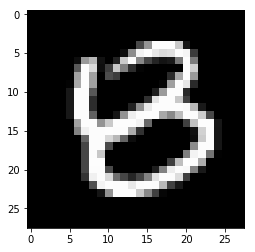

In [7]:
plt.gray()
plt.imshow(images[0].squeeze()) #Note: We get the image 0 from the batch. Thus, it becomes 3 dim. We would 'squeeze' so that it becomes 2 dim.

## NN Module

- this is where we define our Neural Network Architecture

In [29]:
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, D_in, H1, H2, D_out):
        """
            In the constructor we instantiate three nn.Linear modules and assign them as
            member variables.
            Note: we just define components. we have not yet connected them. 
            If you think of it like a graph, we are only declaring nodes, we have not declared edges

            Input:
            D_in: a scalar value that defines the no. of neurons on layer 0 (a.k.a. input layer)
            H1: number of neurons in layer 1
            H2: number of neurons in layer 2
            D_out: number of neurons in layer 3
        """
        super(MLP, self).__init__() #Call the parent class

        self.linear1 = nn.Linear(D_in,H1) # Linear => Linear Transformation. In equation, this is the same as Wx + b.
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(H1,H2)
        self.relu2 = nn.ReLU()
        self.linear3 = nn.Linear(H2,D_out)
        self.softmax = nn.LogSoftmax(dim=1) # Softmax is simply sigmoid for multiple classes. That is, if we only have two classes, softmax == sigmoid.
        #Note: We need softmax/sigmoid at the end if it's a classification task. If not, we skip this step.

    def forward(self, x0):
        """
          This is where you define your forward propagation.
          In other words, this is where we combine and connect all the components we defined above.

          Input:
          x0 = the actual image in batch

        """
        # Method View = reshape the tensor into a different dimension.
        # x0.shape[0] = we get the first dim of the image shape. Recall: This would be batch_size
        # -1 = The -1 as the second argument means compute the remaining and that would be my second dimension.
        # Thus, the whole line below means, I want to reshape this batch of images by doing the ff:
        # The first dim of this new 'view' would be based on the first dim of this image. In this case, I would get 64
        # The second dim of this new 'view' would be computed based on the remaining pixels left. Thus, it would be 28*28=784.
        # Thus, The new view would be (64,784)
        x0 = x0.view(x0.shape[0],-1)
        x1 = self.relu1(self.linear1(x0))
        x2 = self.relu2(self.linear2(x1))
        x3 = self.softmax(self.linear3(x2)) 

        return x3

## Model Configurations

In [24]:
seed = 24 #Fave Number. Kobe == 24
torch.manual_seed(seed) # This is set in order to have reproducible and comparable results


D_in = 784 # Number of input neuron in layer 0 (input layer)
H1 = 150   # Number of neuron in layer 1
H2 = 48    # number of neuron in layer 2
D_out = 10 # number of neuron in layer 3 (output layer)

model = MLP(D_in,H1,H2,D_out)

epochs = 10 # Number of times it would repeat the whole training process

In [25]:
# Define the cost function
# criterion = torch.nn.MSELoss(reduction='sum')
criterion = nn.NLLLoss() #This is good for classification task

# Define how we would update the weights
optimizer = torch.optim.SGD(model.parameters(),lr=0.0001,momentum=0.9)

# Model Training and Evaluation Framework v1
- We train the model using familiar python syntaxes

In [28]:
count = 0
model.train()
for i in range(epochs):
    running_loss = 0
    for images, labels in trainDataLoader:
        # Clear gradients
        optimizer.zero_grad()

        with torch.set_grad_enabled(True):
          # Forward propagation
          y_pred = model(images)

          #compute the loss
          loss = criterion(y_pred,labels)

          # Calculating gradients
          loss.backward()

          # Update parameters
          optimizer.step()

        count += 1
        running_loss += loss.item() * images.size(0)

    else:
        print("Epoch: {} Training loss: {} ".format(i, running_loss/len(trainDataLoader)))

Epoch: 0 Training loss: 28.615031921533124 
Epoch: 1 Training loss: 27.306841079105954 
Epoch: 2 Training loss: 26.246000328551986 
Epoch: 3 Training loss: 25.351701895057012 
Epoch: 4 Training loss: 24.59066733368424 
Epoch: 5 Training loss: 23.9370984349932 
Epoch: 6 Training loss: 23.371875348121627 
Epoch: 7 Training loss: 22.8667521517414 
Epoch: 8 Training loss: 22.40548612161486 
Epoch: 9 Training loss: 21.998763328930462 


## Visualize the Test Set
- In this case, we try to get familiarize ourselves on how to use model for predicting 'out-of-training' samples and on how to visualize it

Predicted digit: 8
True Label: 8


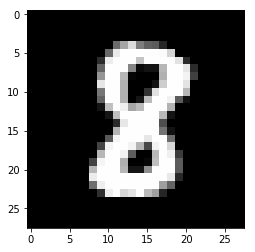

In [30]:
testIter = iter(testDataLoader) #Convert Loader into built-in Python iterable

test_images, test_labels = testIter.next() #Get the next element. Note: each element is has a dim of (batch_size,no_channels,width,height)

# As I want to perform inference, disable gradient computation
with torch.set_grad_enabled(False):  
    y = model(test_images[0]) #Perform computation. Based on my model architecture, my expected output is 1,10
    _, y_result = torch.max(y, 1) #Get the maximum along rows.

print("Predicted digit: {}".format(y_result[0]))
print("True Label: {}".format(test_labels[0]))
plt.imshow(test_images[0].squeeze())

## Evaluate our Model
- We now use the whole testset to understand how well is our model.
- For this one, we use accuracy as a metric

In [31]:
correct_counter = 0
all_counter = 0
model.eval()
for test_images, test_labels in testDataLoader:

    with torch.set_grad_enabled(False):
        y = model(test_images)

        # Get highest value at column
        _, preds = torch.max(y, 1)

    correct_counter += torch.sum(preds == test_labels)
    

all_counter += len(testDataLoader.dataset)

print("Accuracy: {:.4f}".format(correct_counter.double() / all_counter * 100))
    
    

Accuracy: 90.6300


At this point in time, we are able to complete an end-to-end machine learning project using Artificial Neual Network. 

## Model Training and Evaluation Framework v2
- Although the above training works well, it is highly recommended if you can add more insights from the model itself.
- It would be easier for us to know if the model status (i.e. bias/variance) if we can see the training and testing loss for each epoch

In [32]:
for i in range(epochs):
  
    print("epoch {}/{}".format(i,epochs-1))

    # Training phase
    running_loss = 0
    correct_counter = 0
    all_counter = 0
    model.train()
    for images, labels in trainDataLoader:
        # Clear gradients
        optimizer.zero_grad()

        with torch.set_grad_enabled(True):
            # Forward propagation
            y_pred = model(images)

            # Get highest value at column
            _, preds = torch.max(y_pred, 1)

            #compute the loss
            loss = criterion(y_pred,labels)

            # Calculating gradients
            loss.backward()

            # Update parameters
            optimizer.step()

        running_loss += loss.item() * images.size(0)
        correct_counter += torch.sum(preds == labels)

    ave_loss = running_loss/len(trainDataLoader)
    all_counter += len(trainDataLoader.dataset)  
    accuracy = (correct_counter.double() / all_counter).item()

    print("Epoch: {} Training Loss: {:.4f} Training Acc: {:.4f}".format(i, ave_loss, accuracy*100))

    # Evaluation Phase
    correct_counter = 0
    all_counter = 0
    running_loss = 0 
    model.eval()
    for test_images, test_labels in testDataLoader:

        with torch.set_grad_enabled(False):
            y = model(test_images)

            # Get highest value at column
            _, preds = torch.max(y, 1)

            #compute the loss
            loss = criterion(y,test_labels)

        running_loss += loss.item() * test_images.size(0)
        correct_counter += torch.sum(preds == test_labels)

    ave_loss = running_loss / len(testDataLoader)
    all_counter += len(testDataLoader.dataset)
    accuracy = (correct_counter.double() / all_counter).item()

    print("Epoch: {} Validation loss: {:.4f} Val Acc: {:.4f}".format(i, ave_loss, accuracy * 100 ))

epoch 0/9
Epoch: 0 Training Loss: 21.6124 Training Acc: 90.3450
Epoch: 0 Validation loss: 20.6249 Val Acc: 90.6600
epoch 1/9
Epoch: 1 Training Loss: 21.2700 Training Acc: 90.4850
Epoch: 1 Validation loss: 20.3244 Val Acc: 90.9600
epoch 2/9
Epoch: 2 Training Loss: 20.9437 Training Acc: 90.6033
Epoch: 2 Validation loss: 20.0329 Val Acc: 90.9800
epoch 3/9
Epoch: 3 Training Loss: 20.6367 Training Acc: 90.7367
Epoch: 3 Validation loss: 19.8326 Val Acc: 91.0100
epoch 4/9
Epoch: 4 Training Loss: 20.3676 Training Acc: 90.8100
Epoch: 4 Validation loss: 19.4894 Val Acc: 91.0800
epoch 5/9
Epoch: 5 Training Loss: 20.0931 Training Acc: 90.9500
Epoch: 5 Validation loss: 19.2312 Val Acc: 91.2700
epoch 6/9
Epoch: 6 Training Loss: 19.8312 Training Acc: 91.0350
Epoch: 6 Validation loss: 19.0149 Val Acc: 91.3500
epoch 7/9
Epoch: 7 Training Loss: 19.5964 Training Acc: 91.2133
Epoch: 7 Validation loss: 18.7947 Val Acc: 91.4500
epoch 8/9
Epoch: 8 Training Loss: 19.3666 Training Acc: 91.2683
Epoch: 8 Validat

## Model Training and Evaluation Framework v2.1
- Ealier, we developed the full training and test routine.
- However, it's too lengthy and wordy. We can refactor it so that we can improve reusability and readability

In [33]:
dataloader = {}
dataloader['train'] = trainDataLoader
dataloader['val'] = testDataLoader
for i in range(epochs):
  
    print("epoch {}/{}".format(i,epochs-1))
    for phase in ["train","val"]:
        # Training phase
        running_loss = 0
        correct_counter = 0
        all_counter = 0
        if phase == 'train':
            model.train()
        else:
            model.eval()
            
        for images, labels in dataloader[phase]:
            # Clear gradients
            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                # Forward propagation
                y_pred = model(images)

                # Get highest value at column
                _, preds = torch.max(y_pred, 1)

                #compute the loss
                loss = criterion(y_pred,labels)
            
            if phase == 'train':
                # Calculating gradients
                loss.backward()

                # Update parameters
                optimizer.step()

            running_loss += loss.item() * images.size(0)
            correct_counter += torch.sum(preds == labels)

        ave_loss = running_loss/len(dataloader[phase])
        all_counter += len(dataloader[phase].dataset)  
        accuracy = (correct_counter.double() / all_counter).item()

        print("Epoch: {} {} Loss: {:.4f} Acc: {:.4f}".format(i, phase, ave_loss, accuracy*100))

epoch 0/9
Epoch: 0 train Loss: 18.9371 Acc: 91.4633
Epoch: 0 val Loss: 18.2302 Acc: 91.7100
epoch 1/9
Epoch: 1 train Loss: 18.7291 Acc: 91.5850
Epoch: 1 val Loss: 18.0234 Acc: 91.8700
epoch 2/9
Epoch: 2 train Loss: 18.5378 Acc: 91.6700
Epoch: 2 val Loss: 17.8852 Acc: 91.8500
epoch 3/9
Epoch: 3 train Loss: 18.3560 Acc: 91.7050
Epoch: 3 val Loss: 17.6857 Acc: 91.9900
epoch 4/9
Epoch: 4 train Loss: 18.1639 Acc: 91.8467
Epoch: 4 val Loss: 17.5239 Acc: 92.0200
epoch 5/9
Epoch: 5 train Loss: 17.9892 Acc: 91.9250
Epoch: 5 val Loss: 17.3920 Acc: 92.0800
epoch 6/9
Epoch: 6 train Loss: 17.8282 Acc: 91.9533
Epoch: 6 val Loss: 17.2497 Acc: 92.1900
epoch 7/9
Epoch: 7 train Loss: 17.6609 Acc: 92.0117
Epoch: 7 val Loss: 17.0760 Acc: 92.2200
epoch 8/9
Epoch: 8 train Loss: 17.4938 Acc: 92.0967
Epoch: 8 val Loss: 16.9600 Acc: 92.3800
epoch 9/9
Epoch: 9 train Loss: 17.3308 Acc: 92.2000
Epoch: 9 val Loss: 16.8140 Acc: 92.3600


## Model Training and Evaluation Framework v3
At this point, we want to make more reusable by doing the ff:
    1. As training is very routinary, let's put a boilerplate `trainer`
    2. As evaluation during training and validation is routinary, let's create an `evaluator`
    3. Let's make the logging of results, extensible

In [37]:
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss

trainer = create_supervised_trainer(model,optimizer,criterion)
evaluator = create_supervised_evaluator(model,metrics={'accuracy':Accuracy(),
                                                      'loss':Loss(criterion)})

@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(engine):
    evaluator.run(trainDataLoader)
    avg_accuracy = evaluator.state.metrics['accuracy']
    avg_loss = evaluator.state.metrics['loss']
    epoch = engine.state.epoch
    print("Epoch: {} train Loss: {:.4f} Acc: {:.4f}".format(epoch, avg_loss, avg_accuracy*100))
    pass

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(engine):
    evaluator.run(testDataLoader)
    avg_accuracy = evaluator.state.metrics['accuracy']
    avg_loss = evaluator.state.metrics['loss']
    epoch = engine.state.epoch
    print("Epoch: {} Val Loss: {:.4f} Acc: {:.4f}".format(epoch, avg_loss, avg_accuracy*100))
    

trainer.run(trainDataLoader, max_epochs=epochs)

Epoch: 1 train Loss: 0.2067 Acc: 94.0417
Epoch: 1 Val Loss: 0.2089 Acc: 93.9500
Epoch: 2 train Loss: 0.2047 Acc: 94.1400
Epoch: 2 Val Loss: 0.2070 Acc: 94.0600
Epoch: 3 train Loss: 0.2038 Acc: 94.0750
Epoch: 3 Val Loss: 0.2061 Acc: 94.0100
Epoch: 4 train Loss: 0.2020 Acc: 94.1500
Epoch: 4 Val Loss: 0.2046 Acc: 94.0700
Epoch: 5 train Loss: 0.2000 Acc: 94.2667
Epoch: 5 Val Loss: 0.2030 Acc: 94.1400
Epoch: 6 train Loss: 0.1988 Acc: 94.2750
Epoch: 6 Val Loss: 0.2014 Acc: 94.1900
Epoch: 7 train Loss: 0.1977 Acc: 94.2883
Epoch: 7 Val Loss: 0.2001 Acc: 94.1700
Epoch: 8 train Loss: 0.1956 Acc: 94.3500
Epoch: 8 Val Loss: 0.1976 Acc: 94.2700
Epoch: 9 train Loss: 0.1939 Acc: 94.4150
Epoch: 9 Val Loss: 0.1971 Acc: 94.3100
Epoch: 10 train Loss: 0.1929 Acc: 94.4817
Epoch: 10 Val Loss: 0.1965 Acc: 94.4100


## Model Training and Evaluation Framework v4
- At this point we are able to think of reusability and abstractions in mind
- Lastly, if we have very expensive training (> 1 day), we want to add a plot so that we can easily see our progress
- For this tutorial, we would utilize one of the famous plotting tools `Visdom`

In [49]:
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss
from visdom import Visdom

trainer = create_supervised_trainer(model,optimizer,criterion)
evaluator = create_supervised_evaluator(model,metrics={'accuracy':Accuracy(),
                                                      'loss':Loss(criterion)})
vis = Visdom()

def create_plot_window(vis, xlabel, ylabel, title):
    return vis.line(X=np.array([1]), Y=np.array([np.nan]), opts=dict(xlabel=xlabel, ylabel=ylabel, title=title))

#Initialize all the plot windows we wanted
train_loss_window = create_plot_window(vis,'#Iterations','Loss','Training Avg Loss')
val_loss_window = create_plot_window(vis,'#Iterations','Loss','Val Avg Loss')
train_acc_window = create_plot_window(vis,'#Iterations','Accuracy','Training Avg Accuracy')
val_acc_window = create_plot_window(vis,'#Iterations','Accuracy','Val Avg Accuracy')


@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(engine):
    evaluator.run(trainDataLoader)
    avg_accuracy = evaluator.state.metrics['accuracy']
    avg_loss = evaluator.state.metrics['loss']
    epoch = engine.state.epoch
    print("Epoch: {} train Loss: {:.4f} Acc: {:.4f}".format(epoch, avg_loss, avg_accuracy*100))
    
    # Update your plots
    vis.line(X=np.array([epoch]),Y=np.array([avg_loss]),win=train_loss_window,update='append')
    vis.line(X=np.array([epoch]),Y=np.array([avg_accuracy]),win=train_acc_window,update='append')
    
    pass

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(engine):
    evaluator.run(testDataLoader)
    avg_accuracy = evaluator.state.metrics['accuracy']
    avg_loss = evaluator.state.metrics['loss']
    epoch = engine.state.epoch

    print("Epoch: {} Val Loss: {:.4f} Acc: {:.4f}".format(epoch, avg_loss, avg_accuracy*100))
    
    # Update your plots
    vis.line(X=np.array([epoch]),Y=np.array([avg_loss]),win=val_loss_window,update='append')
    vis.line(X=np.array([epoch]),Y=np.array([avg_accuracy]),win=val_acc_window,update='append')


trainer.run(trainDataLoader, max_epochs=epochs)

Epoch: 1 train Loss: 0.1800 Acc: 94.8233
Epoch: 1 Val Loss: 0.1850 Acc: 94.5800
Epoch: 2 train Loss: 0.1785 Acc: 94.8517
Epoch: 2 Val Loss: 0.1835 Acc: 94.6900
Epoch: 3 train Loss: 0.1771 Acc: 94.9167
Epoch: 3 Val Loss: 0.1826 Acc: 94.6900
Epoch: 4 train Loss: 0.1756 Acc: 94.9633
Epoch: 4 Val Loss: 0.1810 Acc: 94.8200
Epoch: 5 train Loss: 0.1744 Acc: 94.9867
Epoch: 5 Val Loss: 0.1797 Acc: 94.7400
Epoch: 6 train Loss: 0.1736 Acc: 95.0117
Epoch: 6 Val Loss: 0.1786 Acc: 94.8300
Epoch: 7 train Loss: 0.1719 Acc: 95.0600
Epoch: 7 Val Loss: 0.1775 Acc: 94.8000
Epoch: 8 train Loss: 0.1707 Acc: 95.1483
Epoch: 8 Val Loss: 0.1762 Acc: 94.9000
Epoch: 9 train Loss: 0.1697 Acc: 95.1050
Epoch: 9 Val Loss: 0.1750 Acc: 94.8200
Epoch: 10 train Loss: 0.1685 Acc: 95.2050
Epoch: 10 Val Loss: 0.1744 Acc: 94.9700
